# Intel Scene Classifier

**Objective:** Load the HDF5 version of database which has the extracted features of Intel Scene images and build a model to classify them.

## Read the HDF5 database

In [1]:
import h5py

In [2]:
!pwd

/Users/abalaji/myData/AnalyticsVidhyaHackathon/IntelSceneClassification


In [3]:
db = h5py.File('./output/IntelSceneExtractedFeatures.hdf5', 'r')

In [4]:
db

<HDF5 file "IntelSceneExtractedFeatures.hdf5" (mode r)>

In [5]:
list(db.keys())

['features', 'labels']

In [6]:
len(db["features"])

17034

In [7]:
db["features"].shape

(17034, 2048)

In [8]:
db['labels'].shape

(17034,)

## Configuration

In [9]:
train_sample = 100
val_start_sample_idx = 100
val_stop_sample_idx = 125

## Build Model

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [11]:
## params for logistic regression
## C - Regularization parameter
params = { 'C': [0.0001, 0.001, 0.01, 0.1, 1]}

classifier = GridSearchCV(LogisticRegression(), params, cv=3)

## Train the model

In [12]:
classifier.fit(db['features'][ :train_sample], db['labels'][ :train_sample])

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [13]:
print('Best hyperparameter : {}'.format(classifier.best_params_) )

Best hyperparameter : {'C': 0.01}


## Evaluate the Model

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

In [15]:
y_actuals = db['labels'][val_start_sample_idx:val_stop_sample_idx]
preds = classifier.predict(db['features'][val_start_sample_idx:val_stop_sample_idx])

In [16]:
print(classification_report(y_actuals, preds))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       1.00      1.00      1.00         3
           2       0.50      1.00      0.67         1
           3       1.00      0.75      0.86         4
           4       1.00      1.00      1.00         3
           5       0.82      1.00      0.90         9

   micro avg       0.88      0.88      0.88        25
   macro avg       0.89      0.89      0.86        25
weighted avg       0.91      0.88      0.88        25



In [21]:
print(confusion_matrix(y_actuals, preds))

[[3 0 0 0 0 2]
 [0 3 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 1 3 0 0]
 [0 0 0 0 3 0]
 [0 0 0 0 0 9]]


## Visualize the failed cases¶

In [19]:
import pandas as pd

In [20]:
train_csv_df = pd.read_csv('./dataset/train-scene classification/train.csv')

In [26]:
class_names = { 0: 'buildings',
               1: 'forest',
               2: 'glacier',
               3: 'mountain',
               4: 'sea',
               5: 'street'
             }

In [17]:
fail_index = [ i  for i in range(0,len(y_actuals)) if y_actuals[i] != preds[i]]

In [18]:
fail_index

[0, 6, 10]

In [24]:
fail_df = pd.DataFrame(columns=['image_name', 'orig_label', 'pred'])

for idx in fail_index:
    f_idx = idx + val_start_sample_idx
    img_name = train_csv_df['image_name'][f_idx]
    #wrong_predictions.append(img_name)
    fail_df = fail_df.append({ 'image_name': img_name, 
                      'orig_label' : train_csv_df['label'][f_idx], 
                       'pred' : preds[idx]}, ignore_index=True)

In [25]:
fail_df

,image_name,orig_label,pred
0,142.jpg,0,5
1,153.jpg,3,2
2,158.jpg,0,5


In [27]:
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

./dataset/train-scene classification/train/142.jpg


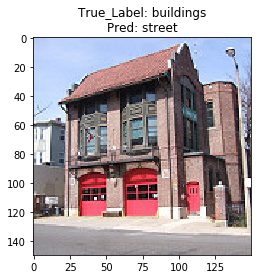

./dataset/train-scene classification/train/153.jpg


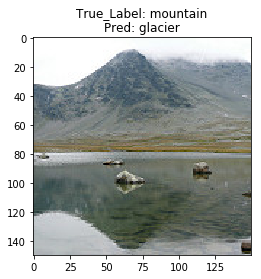

./dataset/train-scene classification/train/158.jpg


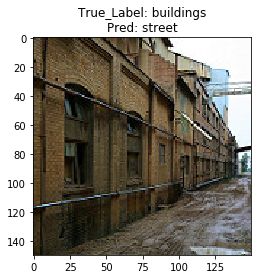

In [32]:
failed_imgs = []
cnt=0
for img_name in fail_df['image_name']:
    file_loc = './dataset/train-scene classification/train/' + img_name
    print(file_loc)
    img = cv2.imread(file_loc)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    ##
    true_label = 'True_Label: ' + class_names[fail_df['orig_label'][cnt]]
    pred       = 'Pred: ' + class_names[fail_df['pred'][cnt]]
    cnt = cnt + 1
    plt.imshow(img)
    plt.title(true_label + '\n' + pred)
    plt.show()
    failed_imgs.append(img)

## Save the Model

In [22]:
import pickle

In [23]:
classifier.best_estimator_

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [24]:
model_file = './model/IntelSceneClassifier.pickle'

In [25]:
f = open(model_file, 'wb')

In [26]:
f.write(pickle.dumps(classifier.best_estimator_))
f.close()

## Close the Database

In [27]:
db.close()